In [71]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

## Imports

In [72]:
pip install pytube pydub

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [73]:
from matplotlib import pyplot as plt 
import tensorflow as tf 
import tensorflow_io as tfio
from pytube import Playlist, YouTube
from pydub import AudioSegment
import numpy as np
import librosa

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

## Build Audio Download Function

In [74]:
"""
twofour = Playlist('https://www.youtube.com/watch?v=Q6JDOyDqOFs&list=PLel4r-3d96fa-eKRp7CIW6I6xWFW5-3Dx&pp=iAQB')

twofour.videos[1].streams.filter(only_audio=True) # get itags for audio

for video in twofour.videos[0:100]:
    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag
    audio.download(output_path='2-4 March', filename_prefix='2-4 March ')
    
strathspey = Playlist('https://www.youtube.com/watch?v=EvX_Tkv-j-c&list=PLel4r-3d96fZ9w3RAhwhel5ud8YWk4Jre&pp=iAQB')

for video in strathspey.videos[0:100]:
    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag
    audio.download(output_path='Strathspey', filename_prefix='Strathspey ')
    
reel = Playlist('https://www.youtube.com/watch?v=TsM7C4ZYmwY&list=PLel4r-3d96fbxHwtJQuZoOkPWve7J02UJ&pp=iAQB')

for video in reel.videos[0:150]:
    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag
    audio.download(output_path='Reel', filename_prefix='Reel ')
"""

"\ntwofour = Playlist('https://www.youtube.com/watch?v=Q6JDOyDqOFs&list=PLel4r-3d96fa-eKRp7CIW6I6xWFW5-3Dx&pp=iAQB')\n\ntwofour.videos[1].streams.filter(only_audio=True) # get itags for audio\n\nfor video in twofour.videos[0:100]:\n    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag\n    audio.download(output_path='2-4 March', filename_prefix='2-4 March ')\n    \nstrathspey = Playlist('https://www.youtube.com/watch?v=EvX_Tkv-j-c&list=PLel4r-3d96fZ9w3RAhwhel5ud8YWk4Jre&pp=iAQB')\n\nfor video in strathspey.videos[0:100]:\n    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag\n    audio.download(output_path='Strathspey', filename_prefix='Strathspey ')\n    \nreel = Playlist('https://www.youtube.com/watch?v=TsM7C4ZYmwY&list=PLel4r-3d96fbxHwtJQuZoOkPWve7J02UJ&pp=iAQB')\n\nfor video in reel.videos[0:150]:\n    audio = video.streams.get_by_itag(140) # 140 is higher quality audio itag\n    audio.download(output_path='Reel', filename_prefix='Ree

## Build Data Loading Function

In [75]:
m = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/2-4 March Chanter/2-4 March 24th Guards Brigade at Anzio.wav'
s = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Strathspey Chanter/Strathspey A.A Cameron for Ricky.wav'
r = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Reel Chanter/Reel Becky Ewen for Ricky.wav'

## Define Audio Processing Functions

In [76]:
def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    audio_normalized = audio / max_val
    return audio_normalized

def load_wav_mfccs_mono(filename):
    # Read the WAV file using TensorFlow
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=44100)
    wav = wav.numpy()

    # Normalize audio
    wav = normalize_audio(wav)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=wav, sr=44100, n_mfcc=13)

    return mfccs

## Plot MFCCs

In [77]:
mwave = load_wav_mfccs_mono(m)
swave = load_wav_mfccs_mono(s)
rwave = load_wav_mfccs_mono(r)

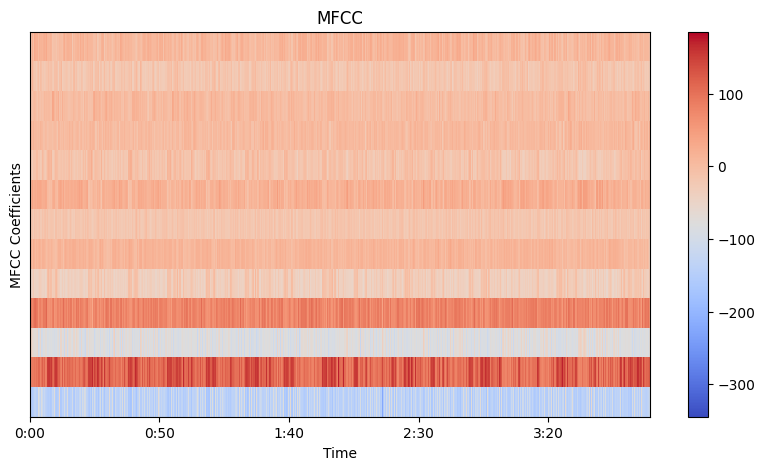

In [78]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(mwave, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

## Create Tensorflow Datasets

In [79]:
MARCH = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/2-4 March Chanter'
STRATHSPEY = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Strathspey Chanter'
REEL = '/kaggle/input/chanter-marches-strathspeys-and-reels/Tunes/Reel Chanter'

In [80]:
march = tf.data.Dataset.list_files(MARCH+'/*.wav')
strath = tf.data.Dataset.list_files(STRATHSPEY+'/*.wav')
reel = tf.data.Dataset.list_files(REEL+'/*.wav')

## Process All Files

In [81]:
march_data = []
strath_data = []
reel_data = []

for file_path in march:
    mfccs = load_wav_mfccs_mono(file_path.numpy().decode("utf-8"))
    march_data.append(mfccs)

for file_path in strath:
    mfccs = load_wav_mfccs_mono(file_path.numpy().decode("utf-8"))
    strath_data.append(mfccs)

for file_path in reel:
    mfccs = load_wav_mfccs_mono(file_path.numpy().decode("utf-8"))
    reel_data.append(mfccs)

## Pad MFCCs

In [82]:
# Find the maximum length of MFCCs across all data
max_length = max(max(mfcc.shape[1] for mfcc in march_data),
                 max(mfcc.shape[1] for mfcc in strath_data),
                 max(mfcc.shape[1] for mfcc in reel_data))

def pad_mfccs(mfcc, max_length):
    # Pad the MFCCs with zeros to match the max_length
    padded_mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), 'constant')
    return padded_mfcc

# Pad all MFCCs to the maximum length
march_data = [pad_mfccs(mfcc, max_length) for mfcc in march_data]
strath_data = [pad_mfccs(mfcc, max_length) for mfcc in strath_data]
reel_data = [pad_mfccs(mfcc, max_length) for mfcc in reel_data]

# Verify all MFCCs are correctly padded
for mfcc in march_data + strath_data + reel_data:
    assert mfcc.shape[1] == max_length, "Padding error: MFCC lengths are inconsistent"

## Generate Tensorflow Datasets

In [83]:
def generator(data_list, indices):
    for index in indices:
        yield data_list[index]

# Create TensorFlow datasets
def create_dataset(data):
    indices = list(range(len(data)))
    dataset = tf.data.Dataset.from_generator(
        generator, 
        args=(data, indices), 
        output_signature=tf.TensorSpec(shape=(13, max_length), dtype=tf.float32)
    )
    return dataset

march_dataset = create_dataset(march_data)
strath_dataset = create_dataset(strath_data)
reel_dataset = create_dataset(reel_data)

marches = tf.data.Dataset.zip((march_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(march), dtype=tf.int32))))  # Label march as 0
strathspeys = tf.data.Dataset.zip((strath_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(strath), dtype=tf.int32))))  # Label strathspey as 1
reels = tf.data.Dataset.zip((reel_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(reel), dtype=tf.int32) * 2)))  # Label reel as 2

data = marches.concatenate(strathspeys).concatenate(reels)

## Split and Label Datasets

In [84]:
from sklearn.model_selection import train_test_split

# Convert the concatenated dataset to a list of tuples
all_data_padded = list(data)

# Extract features and labels
features = [item[0].numpy() for item in all_data_padded]
labels = [item[1].numpy() for item in all_data_padded]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8, stratify=labels, random_state=seed)

# Convert to TensorFlow datasets
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Train Model

In [85]:
# Assume X_train, X_test, y_train, y_test are already defined
# Convert lists to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Add a channel dimension
X_train = X_train[..., np.newaxis]  # Shape: (num_samples, 13, max_length, 1)
X_test = X_test[..., np.newaxis]    # Shape: (num_samples, 13, max_length, 1)

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np

early_stopping = EarlyStopping(patience=30, restore_best_weights=True, monitor='val_accuracy')

input_shape = (13, max_length, 1)  # Ensure max_length is appropriate for your data

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100


W0000 00:00:1734157975.571287     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3408 - loss: 3.5559 - val_accuracy: 0.5333 - val_loss: 30.7018
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.5760 - loss: 2.7734 - val_accuracy: 0.5333 - val_loss: 15.0195
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.6781 - loss: 2.7976 - val_accuracy: 0.5333 - val_loss: 9.3483
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6815 - loss: 2.9734 - val_accuracy: 0.5333 - val_loss: 6.5304
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7256 - loss: 3.0029 - val_accuracy: 0.5333 - val_loss: 4.9094
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7625 - loss: 2.9497 - val_accuracy: 0.5333 - val_loss: 3.9865
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7533 - loss: 2.8584 - val_accuracy: 0.4667 - val_loss: 3.7005
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.9331 - loss: 2.6870 - val_accuracy: 0.5333 - val_loss: 3.9